In [1]:
"""Evaluation of the model."""
import azureml.core
from azureml.core import Workspace
from azureml import core
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader
import torch
from ml_utils import DiseaseDataset

subscription_id = 'c0e252b0-50d3-44e6-bb79-a007a94e3a9e'
resource_group = 'ml_rg'
workspace_name = 'machine_learning1'

ws = Workspace(subscription_id, resource_group, workspace_name)
ds1 = core.Dataset.get_by_name(ws, name='chexpert')

df_valid = ds1.to_pandas_dataframe()
df = df_valid.copy()
for i, p in enumerate(df_valid["Path"]):
    df["Path"][i] = p[20:]


######  TEST DATA  ######
# Test Labels
labels = list(df.columns[5:])
label_arr_test = df[labels].to_numpy()

/tmp/ipykernel_149832/478173600.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Path"][i] = p[20:]


In [2]:
# Test Data Loader
batch_size = 5
test_data = DiseaseDataset('valid', label_arr_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

######   MODEL  ######
model_path = "/home/azureuser/cloudfiles/code/Users/fatma.dirman/models/densenet121_valid.pth"
model = torch.load(model_path)

def calculate_metrics(pred, target, threshold=0.5):
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    # pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            'accuracy': accuracy_score(target, pred)
            }


In [25]:
def validate(model, dataloader, criterion=torch.nn.BCELoss(), threshold=0.4):
    """
    """
    print('Validating')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        model_result = []
        target_list = []
        for data in dataloader:
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            pred = np.array(outputs.cpu().numpy() > threshold, dtype=float)
            model_result.extend(pred)
            target_tmp = np.array(target.cpu().numpy(), dtype=float)
            target_list.extend(target_tmp)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()

        val_loss = val_running_loss / counter

        return val_loss, model_result, target_list

test_loss, predictions, true_values = validate(model, test_loader)

Validating


/mnt/batch/tasks/shared/LS_root/mounts/clusters/vm-ml1/code/Users/fatma.dirman/ml_utils.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [ ]:
def plot(y_pred, y_labels, chexpert_targets):

    from sklearn.metrics import roc_curve
    from sklearn.metrics import auc
    import matplotlib.pyplot as plt

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    for ii in range(1, np.array(y_pred).shape[1]):
        lbl = [lab[ii] for lab in y_labels[:]]
        prd = [lab[ii] for lab in y_pred[:]]
        fpr_keras, tpr_keras, thresholds_keras = roc_curve(lbl, prd)
        auc_keras = auc(fpr_keras, tpr_keras)
        plt.plot(fpr_keras, tpr_keras, label=chexpert_targets[ii-1] + '(area = {:.3f})'.format(auc_keras))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1514: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: U

Nr of test samples:  234
{'micro/precision': 0.6735294117647059, 'micro/recall': 0.3314037626628075, 'micro/f1': 0.44422890397672166, 'macro/precision': 0.22672258581083832, 'macro/recall': 0.16474430485009664, 'macro/f1': 0.16636204904073054, 'samples/precision': 0.4793447293447293, 'samples/recall': 0.28020960520960514, 'samples/f1': 0.3278351278351279, 'accuracy': 0.05128205128205128}
0.4537135746250761


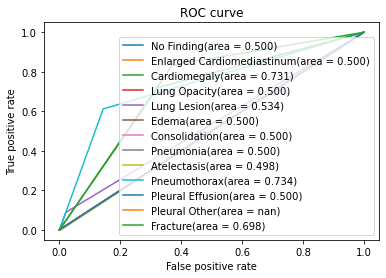

In [26]:
metrics = calculate_metrics(predictions, true_values)

print("Nr of test samples: ", len(label_arr_test))
print(metrics)
print(test_loss)

plot(predictions, true_values, labels)